## Deutsch's algorithm

This algorithm shows one important characteristic of quantum computing: parallelism.

The goal is to know wether a function $f(x)\in\lbrace 0,1\rbrace$ is even or odd. For this we define an oracle $U_f$ such that
$$ U_f\ket{x,y} = \ket{x, y\oplus f(x)}. $$

We have also
$$ f(0)=1\oplus f(1) = 0\oplus f(0), \quad f(1) = 1\oplus f(0) = 0\oplus f(0). $$

In a classical computer, to know if $f(x)$ is even or odd, we'd have to do at least two or three operations. With Deutsch' algorithm we only have to do one compilation.

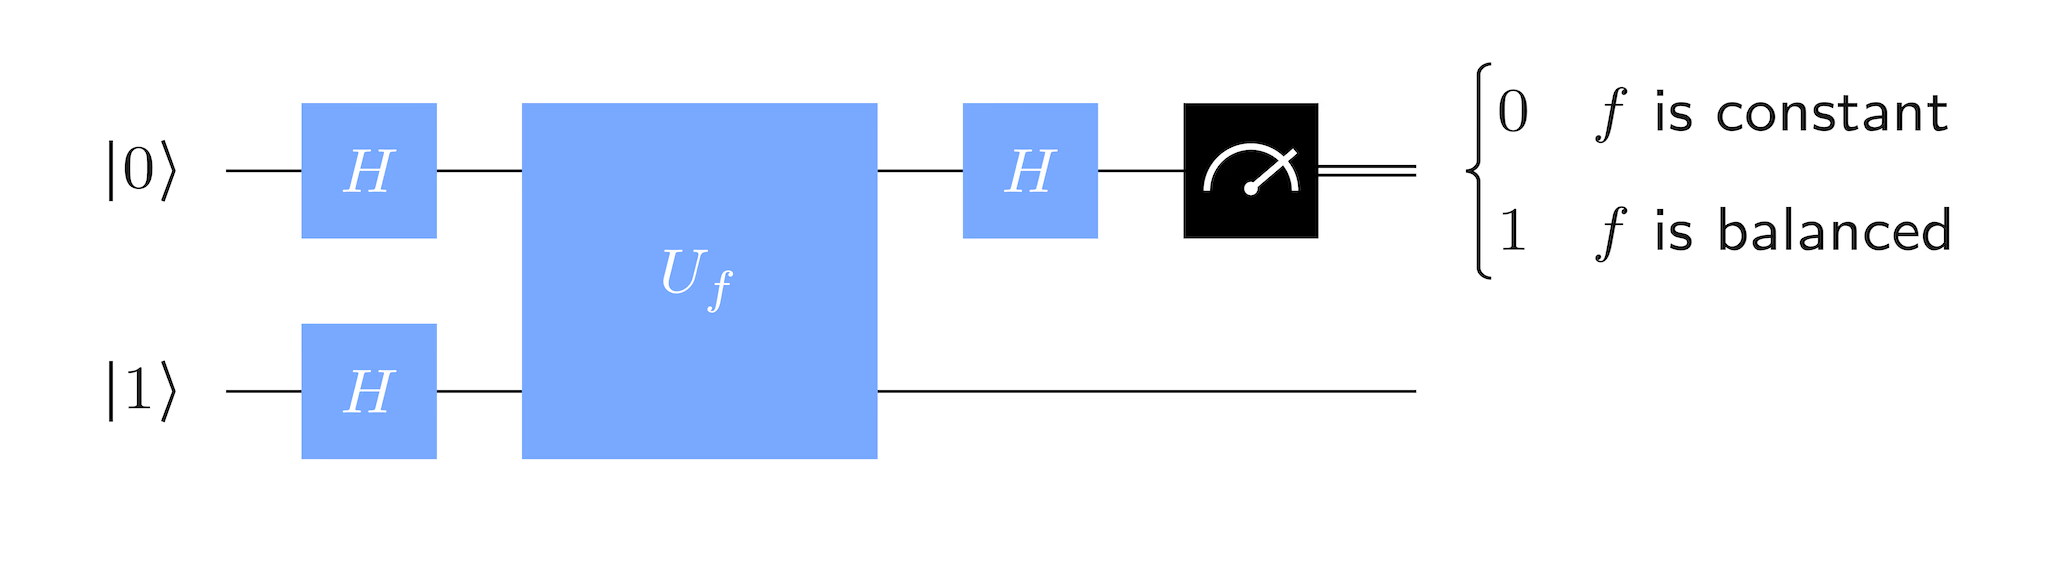

The quantum circuit is above. So

1. $ \ket{0}\ket{1} $
2. $ H(\ket{0}\ket{1}) = \left( \frac{\ket{0}+\ket{1}}{\sqrt{2}} \right)\left( \frac{\ket{0}-\ket{1}}{\sqrt{2}} \right) $
3. We have two cases
- If $f(0)=f(1)$ then $ \left( \frac{\ket{0}+\ket{1}}{\sqrt{2}} \right) \left( \frac{\ket{f(0)}-\ket{1\oplus f(0)}}{\sqrt{2}} \right) $.
- If $f(0)\neq f(1)$ then $ \left( \frac{\ket{0}-\ket{1}}{\sqrt{2}} \right) \left( \frac{\ket{f(0)}-\ket{f(1)}}{\sqrt{2}} \right) $.
4. After applying a Hadamard gate to the first qubit we have:
- If $f(0)=f(1)$ then $ \ket{0} \left( \frac{\ket{f(0)}-\ket{1\oplus f(0)}}{\sqrt{2}} \right) $.
- If $f(0)\neq f(1)$ then $ \\ket{1} \left( \frac{\ket{f(0)}-\ket{f(1)}}{\sqrt{2}} \right) $.

By measuring the first qubit, we know the nature of $f(x)$.

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np
import galois

In [3]:
# define Deutsch's function, this is the oracle
def deutsch_function(case: int):
    '''This function generates a quantum circuit for one of the 4 functions
    from one bit to one bit'''

    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

# quantum circuti for Deutsch' algorithm
def compile_circuit(function: QuantumCircuit):
    '''Compiles a circuito to run the Deutsch's algorithm'''
    # define the number of classical registers
    n = function.num_qubits - 1
    # create the quantum circuit
    qc = QuantumCircuit(QuantumRegister(n+1), ClassicalRegister(n))

    # apply the gates to prepare the initial state
    qc.x(n)
    qc.h(range(n+1))
    qc.barrier()

    # add the oracle
    qc.compose(function, inplace=True)
    qc.barrier()

    # apply hadamard gate to the first qubit
    qc.h(range(n))
    qc.measure(qubit=range(n), cbit=range(n))

    return qc

# function ro run the circuit
def deutsch_algorithm(function: QuantumCircuit):
    '''Run the circuit and determine if the function is constant or balanced'''
    # get the circuit
    qc = compile_circuit(function)

    # run the circuit
    result       = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    # determination
    if measurements[0]=='0':
        return 'constant'
    return 'balanced'

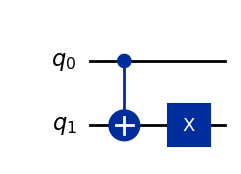

In [4]:
display(deutsch_function(3).draw(output="mpl"))

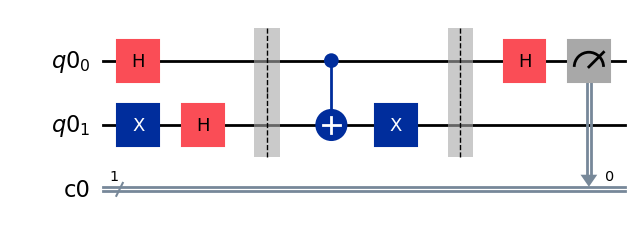

In [5]:
display(compile_circuit(deutsch_function(3)).draw(output="mpl"))

In [6]:
f = deutsch_function(4)
display(deutsch_algorithm(f))

'constant'

## Deutsch-Jozsa algorithm

This algorithm it's the same as the Deutsch' algorithm but extended to $n+1$-qubits.

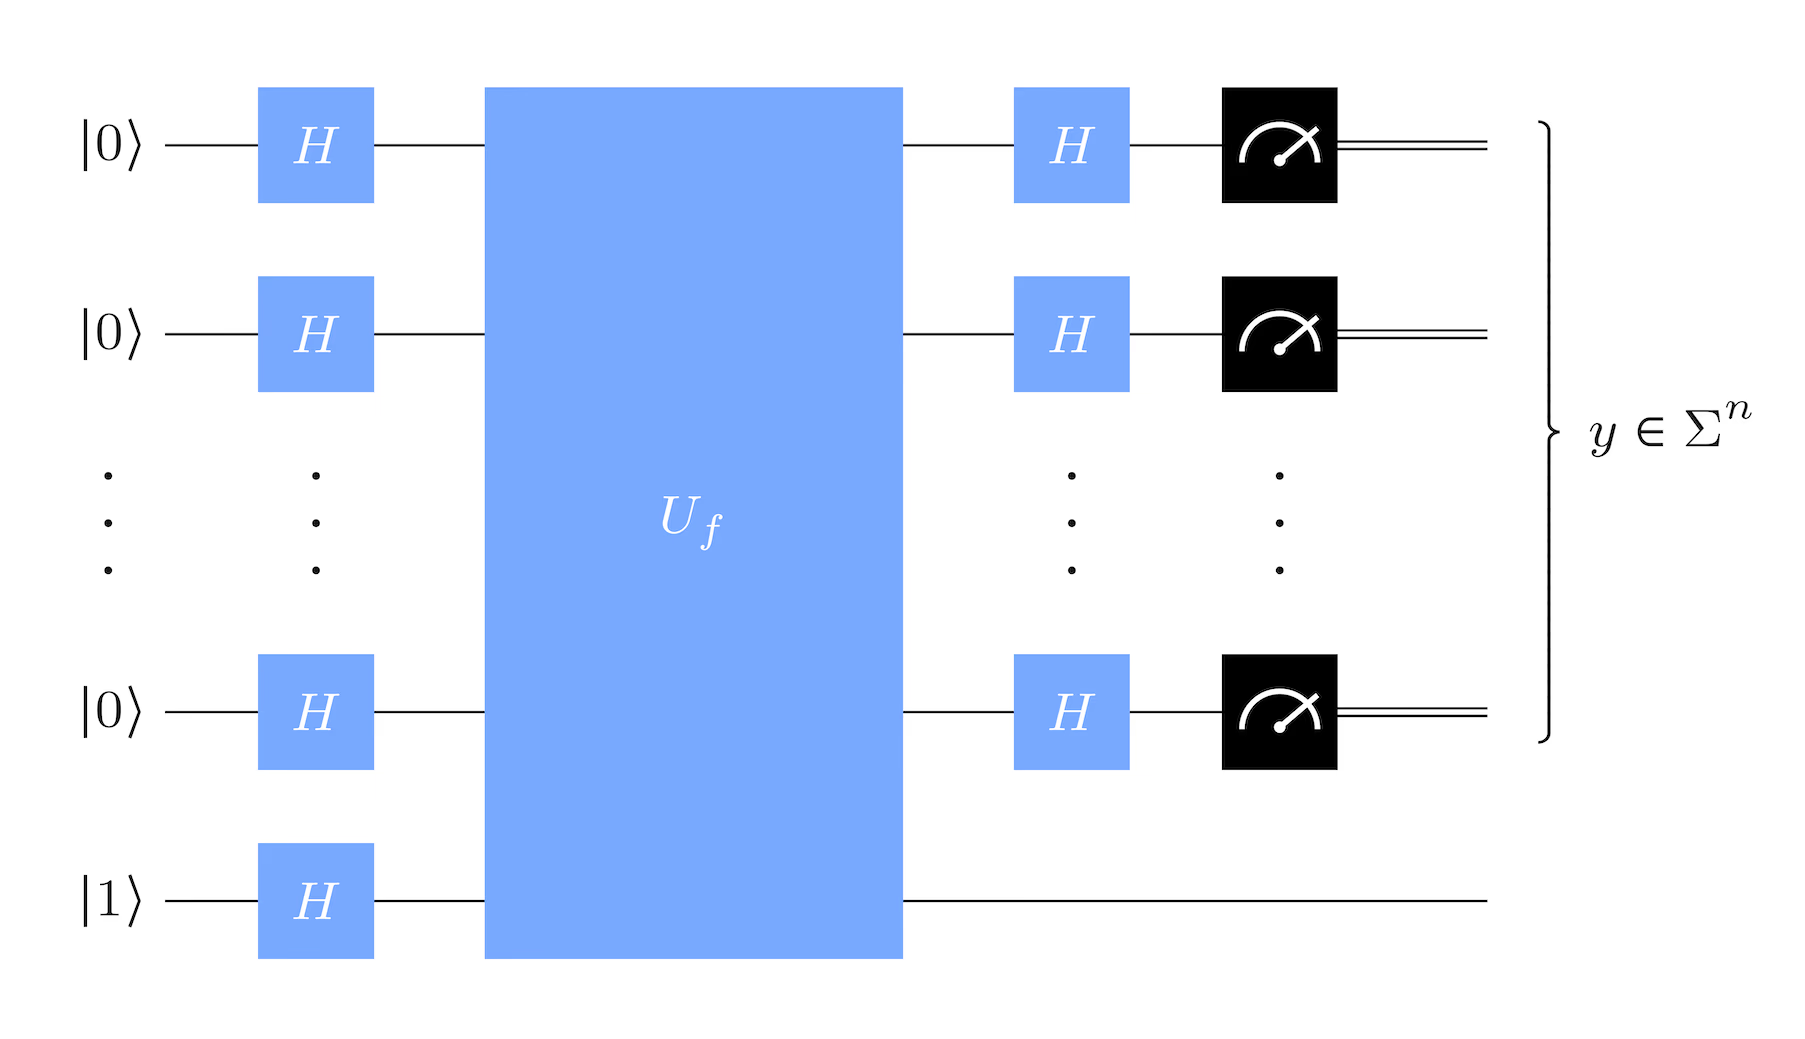

To better understand this, it's important to note that
$$
H^{\otimes n}\ket{\bar{x}} = \sum_{\bar{z}\in\lbrace 0,1\rbrace^n}\frac{1}{\sqrt{2^n}}(-1)^{\bar{x}\cdot\bar{z}}\ket{\bar{z}},
$$
and
$$
U_f\ket{x}\left(\frac{\ket{0}-\ket{1}}{\sqrt{2}}\right) = (-1)^{f(x)}\ket{x}\left(\frac{\ket{0}-\ket{1}}{\sqrt{2}}\right)
$$

We make the same operations but for $n$ qubits. Hence we arrive at
$$ \sum_{\bar{x}, \bar{z}} \frac{1}{2^n}(-1)^{f(x)+\bar{x}\cdot\bar{z}}\ket{\bar{z}}\left(\frac{\ket{0}-\ket{1}}{\sqrt{2}}\right) $$

To know if the function is balanced or constant, we measure the state $\ket{0\cdots 0}$ on the $n-1$ qubits. This because
$$
\bra{0\cdots 0} \sum_{\bar{x}, \bar{z}} \frac{1}{2^n}(-1)^{f(x)+\bar{x}\cdot\bar{z}}\ket{\bar{z}} = \frac{1}{2^n}\sum_{\bar{x}\in\lbrace 0,1\rbrace^n}(-1)^{f(x)},
$$
if we get $\pm 1$ we have $P(\ket{0\cdots 0})=1$, while if we obtain $0$ we have $P(\ket{0\cdots 0})=0$ because of interference.

In a classical algorithm we need $2^n/2 + 1$ operations. But in the Deutsch-Jozsa algorithm we need $k>\log_2(2/\epsilon)$ if we accept an error of value $\epsilon$.

In [7]:
def dj_query(num_qubits):
    # Create a circuit implementing for a query gate for a random function
    # satisfying the promise for the Deutsch-Jozsa problem.

    qc = QuantumCircuit(num_qubits + 1)

    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc

    # Choose half the possible input strings
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()  # Barriers are added to help visualize how the functions are created.
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()

    return qc

# definition of the circuit
def compile_circuit(function: QuantumCircuit):
    '''Compiles the Deutsch-Jozsa algorithm adding the oracle'''
    # get the number of classical registers
    n = function.num_qubits - 1

    # define the quantum circuit
    qc = QuantumCircuit(QuantumRegister(n+1), ClassicalRegister(n))

    # state preparation
    qc.x(n)
    qc.h(range(n+1))
    qc.barrier()

    # add the query/oracle
    qc.compose(function, inplace=True)
    qc.barrier()

    # apply Hadamard gate to the n-1 qubits and measure
    qc.h(range(n))
    qc.measure(qubit=range(n), cbit=range(n))

    return qc

# function to run the circuit
def dj_algorithm(function: QuantumCircuit):
    '''Determine if the function is balanced or constant'''

    # get the circuit
    qc = compile_circuit(function)

    # run the qc
    result       = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    # determination
    if '1' in measurements[0]:
        return 'balanced'
    return 'constant'

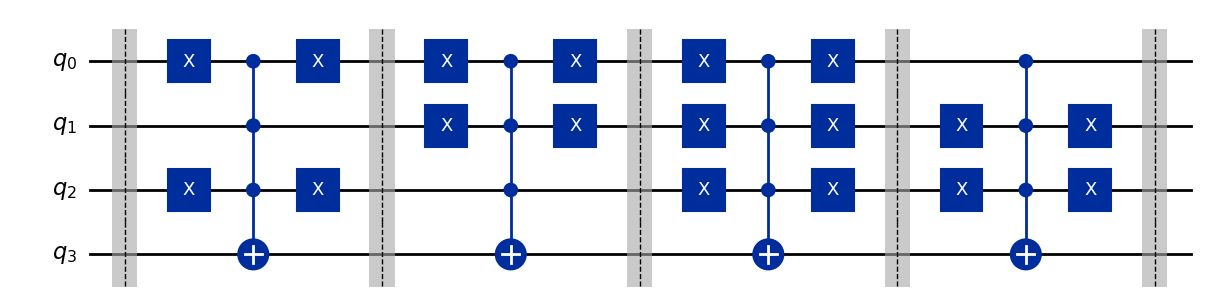

In [8]:
display(dj_query(3).draw(output="mpl"))

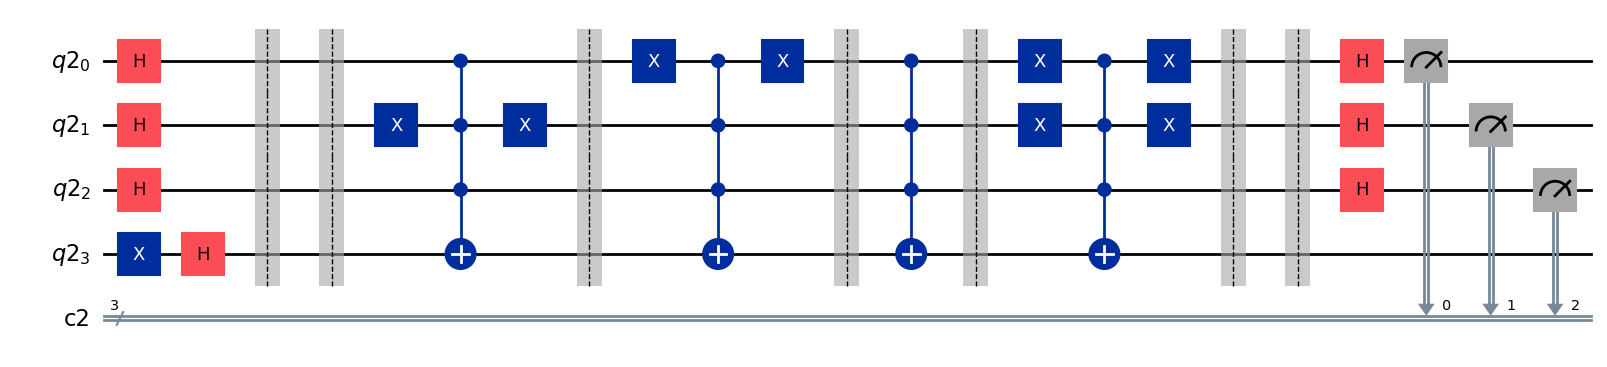

In [9]:
display(compile_circuit(dj_query(3)).draw(output="mpl"))

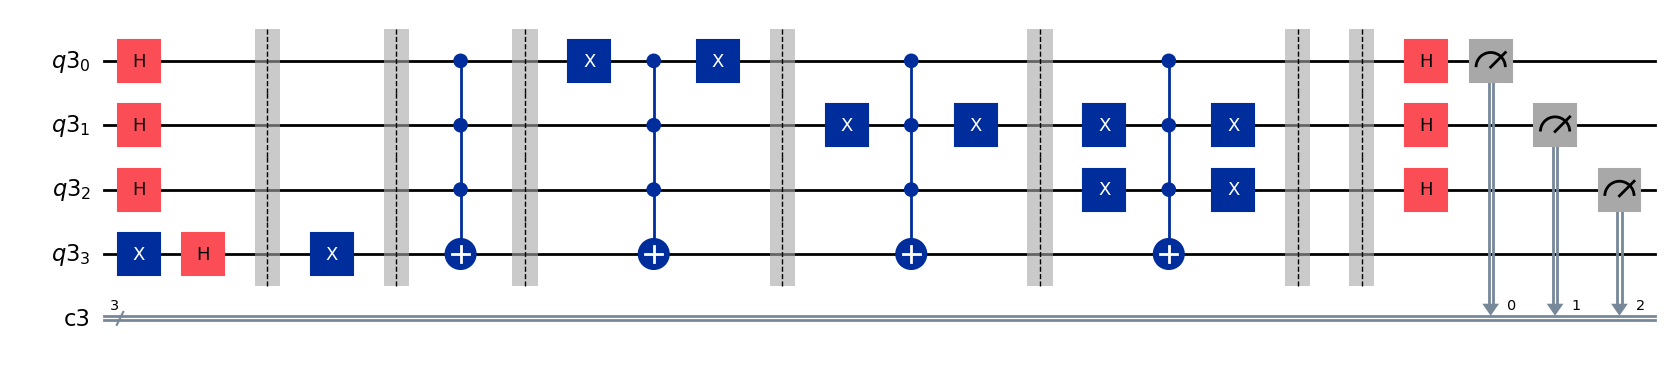

'balanced'

In [10]:
f = dj_query(3)
circuit = compile_circuit(f)
display(circuit.draw("mpl"))
display(dj_algorithm(f))

## Bernstein-Vazirani problem

It's also called the Fourier sampling problem, although there are more general formulations of this problem that also go by that name.

For any two binary strings $x=x_{n-1}\cdots x_0$ and $y=y_{n-1}\cdots y_0$ of length $n$, the binary dot product is
$$ x\cdot y = x_{n-1}y_{n-1}\oplus\cdots\oplus x_0y_0. $$
which is
$$
\begin{aligned}
x\cdot y &= 1, \quad \text{if } x_{n-1}y_{n-1}+\cdots+x_0y_0 \text{ is odd} \\
&= 0, \quad \text{if } x_{n-1}y_{n-1}+\cdots+x_0y_0 \text{ is even}
\end{aligned}
$$

We have a function $f(x):\lbrace 0,1\rbrace^n$ which has $f(x)=s\cdot x$. The goal is to determine $a$.

We use the Deutsch-Jozsa algorithm, in which we arrive at

$$ \sum_{\bar{x}, \bar{z}} \frac{1}{2^n}(-1)^{f(x)+\bar{x}\cdot\bar{z}}\ket{\bar{z}}\ket{-} = \sum_{\bar{x}, \bar{z}} \frac{1}{2^n}(-1)^{s\cdot x+x\cdot z}\ket{\bar{z}}\ket{-}. $$

Because both sums are binary values, we can
$$ \sum_{\bar{x}, \bar{z}} \frac{1}{2^n}(-1)^{s\cdot x+x\cdot z}\ket{z}\ket{-} = \sum_{x, z} \frac{1}{2^n}(-1)^{(s\cdot x)\oplus(z\cdot x)}\ket{z}\ket{-} = \sum_{x, z} \frac{1}{2^n}(-1)^{(s\oplus z)\cdot x}\ket{z}\ket{-} $$

For every binary string we have
$$
\begin{aligned}
\frac{1}{2^n}\sum_{x\in\Sigma^n}(-1)^{y\cdot x} &= 1, \quad \text{if }y=0^n \\
&= 0, \quad \text{if }y\neq 0^n
\end{aligned}
$$

So we arrive at
$$ \sum_{x, z} \frac{1}{2^n}(-1)^{(s\oplus z)\cdot x}\ket{z}\ket{-} = \ket{s}\ket{-} $$
because $s\oplus z=0^n$ if and only if $s=z$. Thus, the measurements reveal precisely the string $s$ we're looking for.

In [11]:
# create the query
def bv_query(s):
    # Create a quantum circuit implementing a query gate for the
    # Bernstein-Vazirani problem.

    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc

# function to run the circuit
def bv_algorithm(function: QuantumCircuit):
    qc = compile_circuit(function)
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    return result.get_memory()[0]

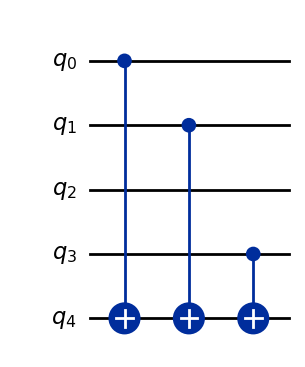

'1011'

In [12]:
display(bv_query("1011").draw(output="mpl"))
display(bv_algorithm(bv_query("1011")))

## Simon's algorithm

Simon's algorithm is significant because it provides an exponential advantage of quantum over classical (including probabilistic) algorithms, and the technique it uses inspired Peter Shor's discovery of an efficient quantum algorithm for integer factorization.

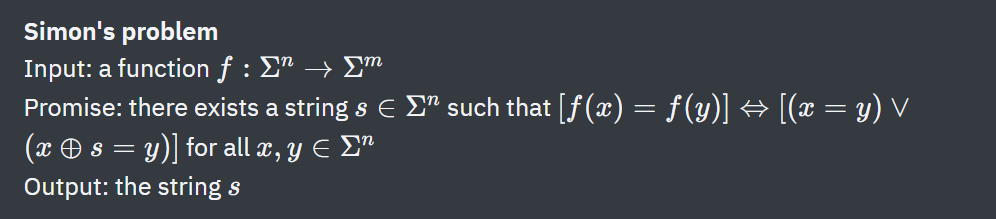

This can be tru for $s=0^n$, and for $s\neq 0^n$ but for some binary periodic condition.

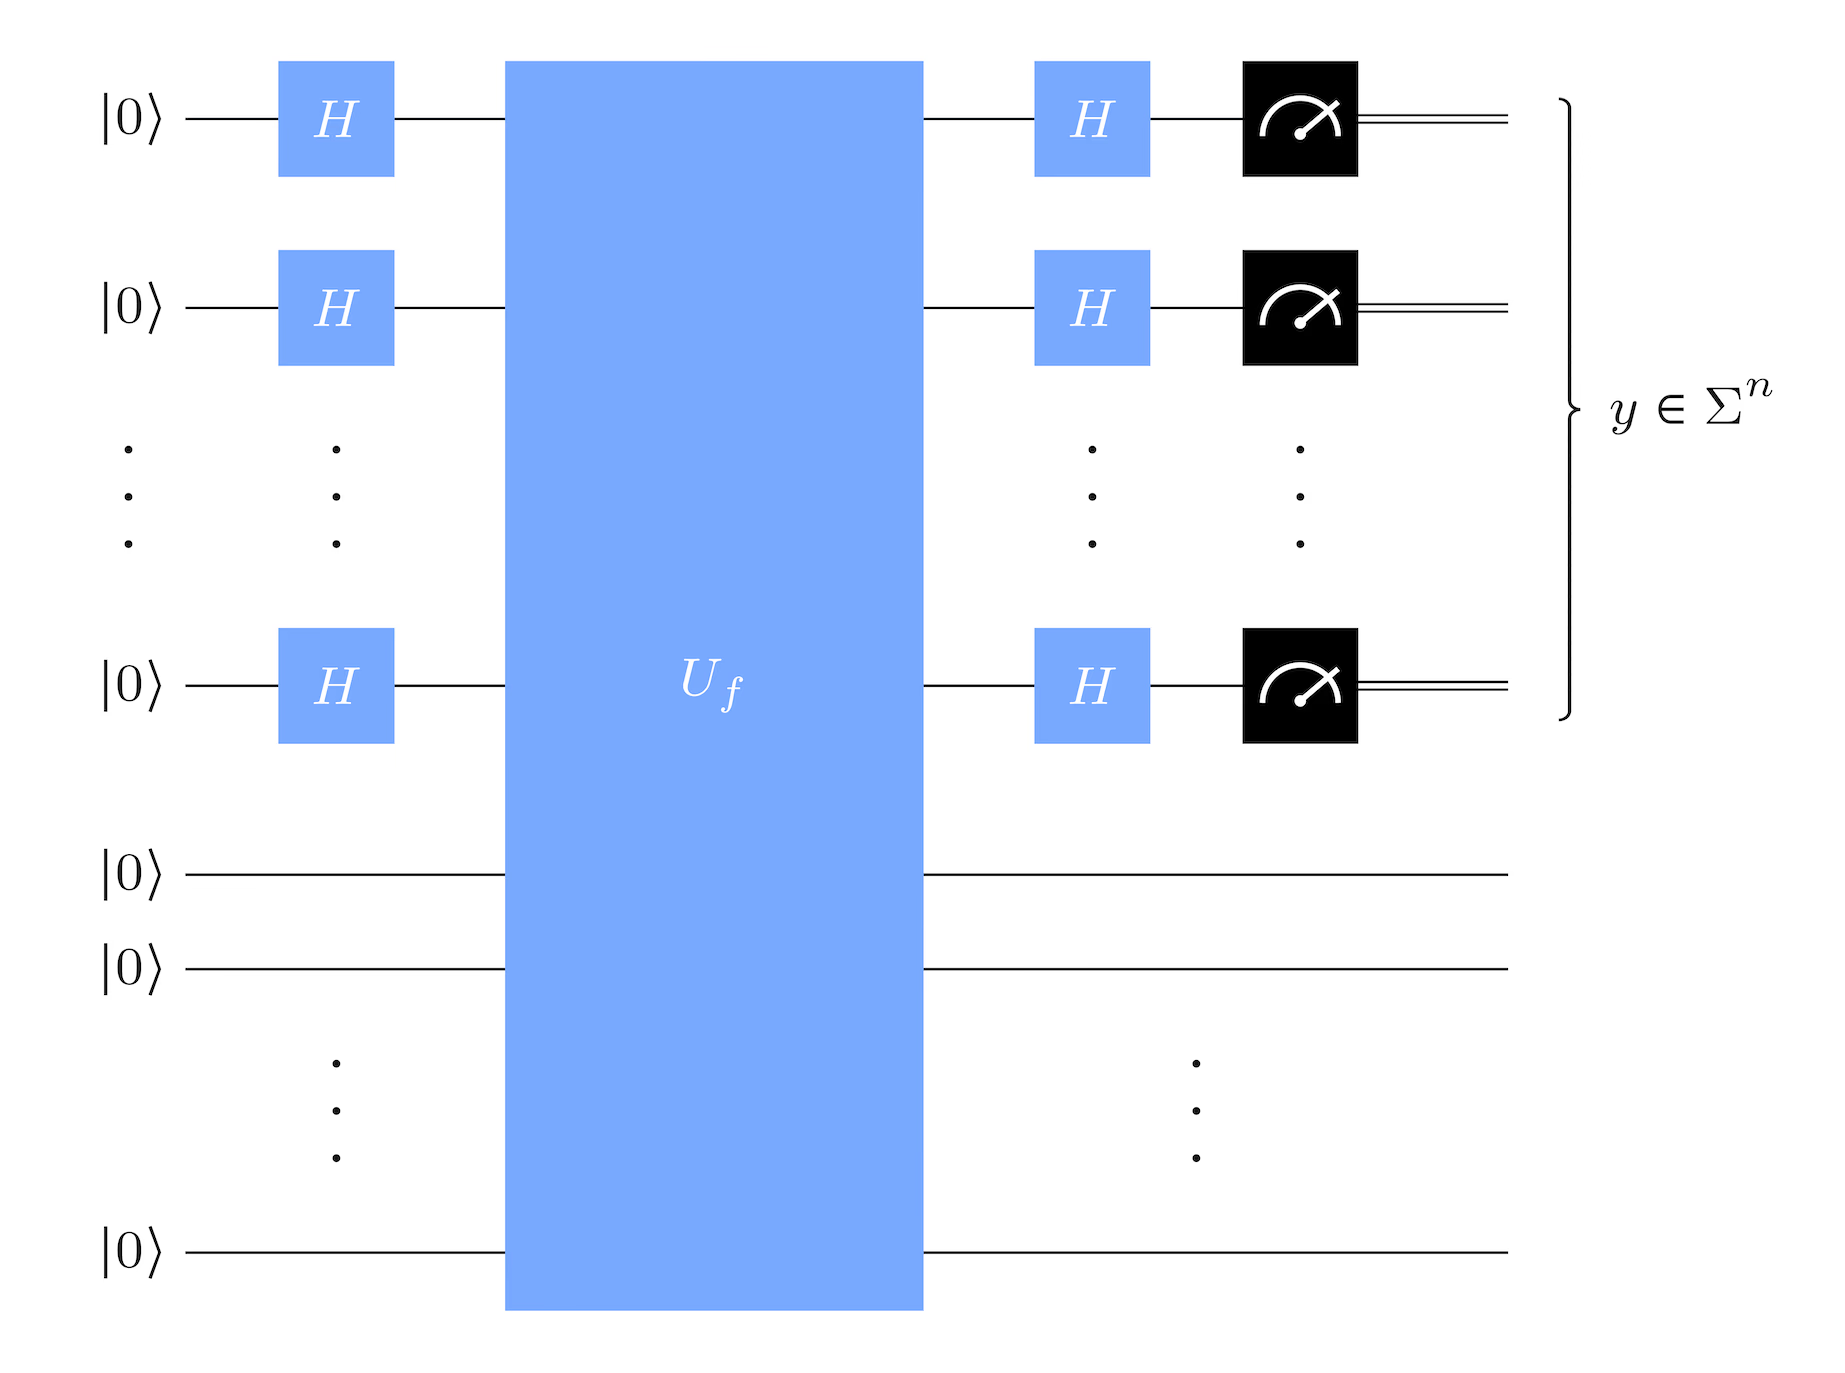

After the first layer of Hadamard gates, we have
$$ \frac{1}{\sqrt{2^n}}\sum_{x\in\Sigma^n}\ket{0^m}\ket{x} $$
and when applying the unitary $U_f$
$$ \frac{1}{\sqrt{2^n}}\sum_{x\in\Sigma^n}\ket{f(x)}\ket{x} \approx \frac{1}{\sqrt{2^n}}\sum_{x\in\Sigma^n}\ket{f(x)}(\ket{x} + \ket{x\oplus s)} $$

When the second layers of Hadamard gates are applied
$$ \frac{1}{2^n}\sum_{y\in\Sigma^n}\sum_{x\in\Sigma^n}(-1)^{x\cdot y}\ket{f(x)}\ket{y} \approx \frac{1}{2^n}\sum_{y\in\Sigma^n}\sum_{x\in\Sigma^n}[(-1)^{x\cdot y} + (-1)^{x\cdot(y\oplus s)}] \ket{f(x)}(\ket{y}+\ket{y\oplus s}) $$

We have
$$ (-1)^{x\cdot y} + (-1)^{x\cdot(y\oplus s)} = (-1)^{x\cdot y} + (-1)^{(x\cdot y)\oplus(x\cdot s)} = (-1)^{x\cdot y}[1+(-1)^{x\cdot s}] $$

The probability of measuring $y$ is 
$$ P(y) = \left| \frac{1}{2^n}\sum_{x\in\Sigma^n}(-1)^{x\cdot y}\ket{f(x)} \right|^2 $$

We can measure something if and only if $x\cdot s=0$. So we have to solve this system to finad $s$. The complexity in the classical protocol is $\mathcal{O}(n)$, in the quantum protocol is $\mathcal{O}(2^n)$.

In [13]:
# definition of Simon's function
def simon_function(s: str):
    # Create a QuantumCircuit implementing a query gate for Simon problem obeying the
    # promise for the hidden string `s`

    # The quantum circuit will have 2n qubits for n being the length of s
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Define a random permutation of all n bit strings. This permutation will
    # effectively hide the string s.
    pi = np.random.permutation(2**n)

    # Now we'll define a query gate explicitly. The idea is to first define a function
    # g(x) = min{x,x ^ s}, which is a very simple function that satisfies the promise.
    # (The operation ^ is the bitwise XOR.) Then we take f to be the composition of g
    # and the random permutation pi. This gives us a random function satisfying the
    # promise for s.

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1

    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2 * n))
    return qc

# Simno's measurments
def simon_measurements(problem: QuantumCircuit, k: int):
    # This is the quantum part of Simon's algorithm. Given a `QuantumCircuit` that
    # implements f, gets k measurement outcomes to be post-processed later.

    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = AerSimulator().run(qc, shots=k, memory=True).result()
    return result.get_memory()

# run
display(simon_measurements(simon_function("10011"),k=12))

['00100',
 '11101',
 '00111',
 '00100',
 '00111',
 '01000',
 '00011',
 '11110',
 '11101',
 '11001',
 '10110',
 '01000']

In [14]:
def simon_algorithm(problem: QuantumCircuit):
    # Given a `QuantumCircuit` that implements a query gate for Simon problem, return
    # the hidden string `s`.

    # Quantum part: run the circuit defined previously k times and gather the measurement
    # results. Replace +10 by +r for any nonnegative integer r depending on desired
    # confidence.

    measurements = simon_measurements(problem, k=problem.num_qubits // 2 + 10)

    # Classical post-processing:

    # 1. Convert measurements of form '11101' to 2D-array of integers
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpret matrix as using arithmetic mod 2, and find null space
    null_space = galois.GF(2)(matrix).null_space()

    # 3. Convert back to a string
    print("Guess for hidden string s: ")
    if len(null_space) == 0:
        # No non-trivial solution; `s` is all-zeros
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))

display(simon_algorithm(simon_function("10011")))

Guess for hidden string s: 


'10011'